In [1]:
from __future__ import division
import numpy as np
import scipy.io as scipy
import matplotlib.pyplot as plt
!pip install mne
import mne
from mne.preprocessing import ICA
from numpy import *
from numpy.fft import *
import mne
# from mne.channels import read_layout
import scipy.signal as signal
from matplotlib.pyplot import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import sklearn
from mne.decoding import CSP

In [2]:
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], scipy.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, scipy.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, scipy.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = scipy.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

In [3]:
ch_pos = {"Fp1": [-2.7, 8.6, 3.6],"Fp2": [2.7, 8.6, 3.6],
"F7": [-6.7, 5.2, 3.6],"F3": [-4.7, 6.2, 8],
"F2": [0, 6.7, 9.5],"F4": [4.7, 6.2, 8],
"F8": [6.7, 5.2, 3.6],
"FC5": [-5.5, 3.2, 6.6],
"FC1": [-3, 3.3, 11],"FC2": [3, 3.3, 11],
"FC6": [5.5, 3.2, 6.6],"T7": [-7.8, 0, 3.6],
"C3": [-6.1, 0, 9.7],"Cz": [0, 0, 12],
"C4": [6.1, 0, 9.7],"T8": [7.8, 0, 3.6],
"TP9": [-7.3, -2.5, 0],"CP5": [-7.2, -2.7, 6.6],
"CP1": [-3, -3.2, 11],"CP2": [3, -3.2, 11],
"CP6": [7.2, -2.7, 6.6], "TP10": [7.3, -2.5, 0],
"P7": [-6.7, -5.2, 3.6],"P3": [-4.7, -6.2, 8],
"Pz": [0, -6.7, 9.5],"P4": [4.7, -6.2, 8],
"P8": [6.7, -5.2, 3.6],"PO9": [-4.7, -6.7, 0],
"O1": [-2.7, -8.6, 3.6],"Oz": [0, -9, 3.6],
"O2": [2.7, -8.6, 3.6],"PO10": [4.7, -6.7, 0]}
montage = mne.channels.make_dig_montage(ch_pos)
info = mne.create_info(ch_names = ['Fp1', 'Fp2', 'F7', 'F3', 'F2', 'F4', 'F8', 'FC5', 'FC1', 
                                   'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP9', 'CP5', 
                                   'CP1', 'CP2', 'CP6', 'TP10', 'P7', 'P3', 'Pz', 'P4', 'P8', 
                                   'PO9', 'O1', 'Oz', 'O2', 'PO10'], sfreq=500, ch_types='eeg')
info = info.set_montage(montage = montage , verbose = None)

<ipython-input-3-8992016fcf52>:23: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  info = info.set_montage(montage = montage , verbose = None)


In [4]:
p2_all = loadmat('P2_AllLifts.mat')
print( "All Lifts loaded")



#these are the series we are looking at for subject 2. Everything except series 1 and 6
trials_included=[2, 3, 4, 5, 7, 8, 9] 

#corresponding row indices in P.AllLifts where each series starts. Index is off by one bc of how python indexes things
trialStartIdx = [28, 62, 96, 130, 192, 226, 260]

#data structure to hold all EEG trials 

eeg_trials = []
emg_trials= []
y_label_eeg = []
y_label_emg = []
CLOSE_VAL = 0
OPEN_VAL = 1

series_counter = 0
trial_counter = 1
i = 0
for s in trials_included:
    # load all the series specified in trials_included
    series_filename = 'WS_P2_S{series}.mat'.format(series = s)
    p_series = loadmat(series_filename)
    print("Series data loaded")
    series_counter = series_counter + 1
    print("series_counter: ", series_counter)

    #identifying the starting row index in p.ALLLifts for the first trial of the current series
    tStart = trialStartIdx[i]
    i += 1
    trial_counter = 1
    #range for the for loop is 34 values bc there are 34 trials in each series
    for trial_num in range(tStart, tStart + 34):
        
        #retrieving the point in time when both fingers touched object
        #index values are one cloumn and one row before target value
        tBothDigitTouch = np.array(p2_all['P']['AllLifts'])[trial_num, 14]
        
        tBothReleased = np.array(p2_all['P']['AllLifts'])[trial_num, 22]
        
        #converting time points to row indices to be accessed in windowed struct
        #500 samples every second, so timepoint should be divided by 0.002
        idxCloseEnd = int(tBothDigitTouch // 0.002) + int(0.8//0.002)
        idxCloseStart = int(tBothDigitTouch // 0.002)- int(0.8//0.002)
        
        idxOpenEnd = int(tBothReleased // 0.002)+ int(0.8//0.002)
        idxOpenStart = int(tBothReleased // 0.002)- int(0.8//0.002)
        
        idxCloseEndEMG = int(tBothDigitTouch // 0.0002) + int(0.8//0.0002)
        idxCloseStartEMG = int(tBothDigitTouch // 0.0002) - int(0.8//0.0002)
        
        idxOpenEndEMG = int(tBothReleased // 0.0002) + int(0.8//0.0002)
        idxOpenStartEMG = int(tBothReleased // 0.0002) - int(0.8//0.0002)

        eeg_trial_close = np.array(p_series['ws']['win'][0]['eeg'])[idxCloseStart:idxCloseEnd].T
        eeg_trial_open = np.array(p_series['ws']['win'][0]['eeg'])[idxOpenStart:idxOpenEnd].T 
        emg_trial_close = np.array(p_series['ws']['win'][0]['emg'])[idxCloseStartEMG:idxCloseEndEMG].T 
        emg_trial_open = np.array(p_series['ws']['win'][0]['emg'])[idxOpenStartEMG:idxOpenEndEMG].T
        
        if(eeg_trial_close.shape[1]== 800):
            eeg_trials.append(eeg_trial_close)
            y_label_eeg.append(CLOSE_VAL)
        
        if(eeg_trial_open.shape[1]== 800):
            eeg_trials.append(eeg_trial_open)
            y_label_eeg.append(OPEN_VAL)
        
        #print("emg close: " , emg_trial_close.shape)
        if(emg_trial_close.shape[1]== 8000):
            #print("appending close")
            emg_trials.append(emg_trial_close)
            y_label_emg.append(CLOSE_VAL)
            
        #print("emg open: " , emg_trial_open.shape)
        if(emg_trial_open.shape[1]== 8000):
            emg_trials.append(emg_trial_open)
            y_label_emg.append(OPEN_VAL)
            #print("appending open")
        
        
        ##if((eeg_trial_close.shape[1]== 800) & (eeg_trial_open.shape[1]== 800) & (emg_trial_open.shape[1]== 8000) & (emg_trial_close.shape[1]== 8000)):
        
#             eeg_trials.append(eeg_trial_open)
#             eeg_trials.append(eeg_trial_close)
#             emg_trials.append(emg_trial_open)
#             emg_trials.append(emg_trial_close)
#             print("appended all")
            
        
        trial_counter = trial_counter +1
eeg_trials = np.asarray(eeg_trials)
emg_trials = np.asarray(emg_trials)
                
                                                            

All Lifts loaded
Series data loaded
series_counter:  1
Series data loaded
series_counter:  2
Series data loaded
series_counter:  3
Series data loaded
series_counter:  4
Series data loaded
series_counter:  5
Series data loaded
series_counter:  6
Series data loaded
series_counter:  7


Creating RawArray with float64 data, n_channels=32, n_times=800
    Range : 0 ... 799 =      0.000 ...     1.598 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


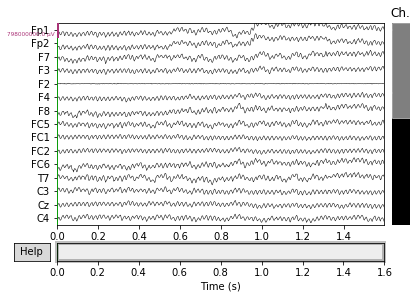

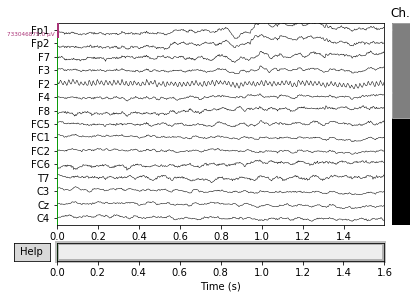

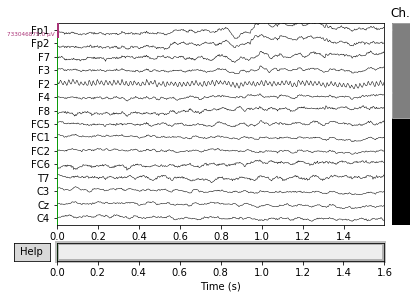

In [5]:
raw = mne.io.RawArray(eeg_trials[1], info, copy = "auto")
ref = mne.set_eeg_reference(raw, ref_channels='average', copy=True, projection=False, ch_type='auto', verbose=None)[0]
raw.plot(n_channels = 15, scalings = "auto")
ref.plot(n_channels = 15, scalings = "auto")


Fitting ICA to data using 32 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 32 components


<ipython-input-6-f9d3a0d70dfd>:2: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  ref.set_montage(montage)


Fitting ICA took 0.5s.
Transforming to ICA space (32 components)
Zeroing out 2 ICA components


/Users/kushaal/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


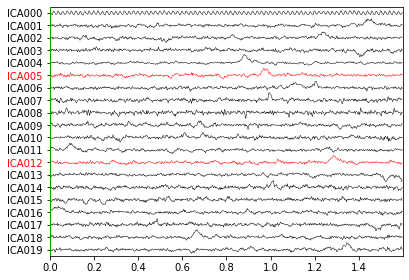

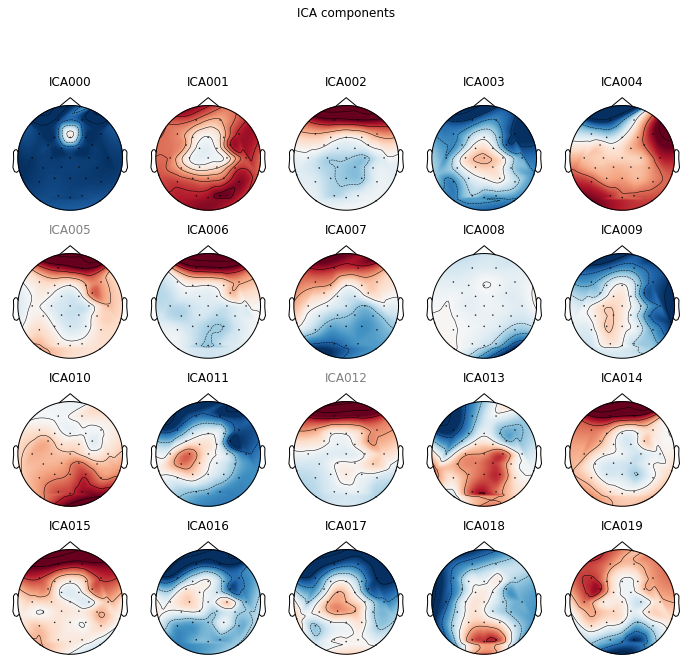

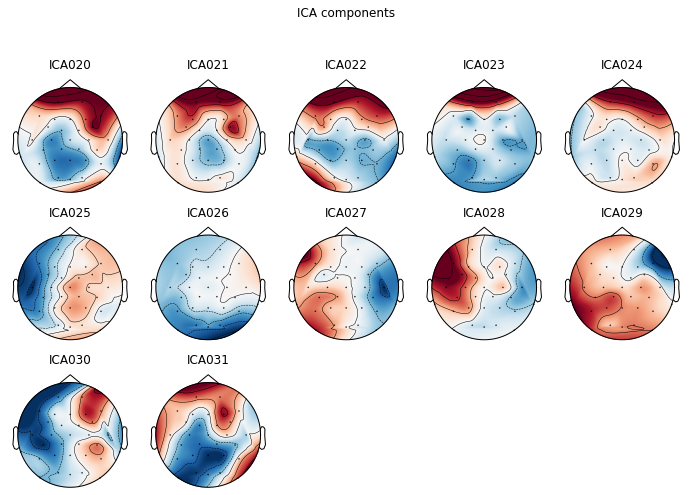

[<Figure size 702x678.24 with 20 Axes>, <Figure size 702x508.68 with 12 Axes>]

In [6]:
ica = ICA( n_components = 32)
ref.set_montage(montage)
ica.fit(raw)
ica.exclude = [5, 12]
reconst_raw = raw.copy() 
ica.apply(reconst_raw)
ica.plot_sources(raw, show_scrollbars=False)
mne.viz.plot_ica_components(ica)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (1.650 sec)



<ipython-input-7-fbe0ba79ac9a>:1: RuntimeWarning: filter_length (825) is longer than the signal (800), distortion is likely. Reduce filter length or filter a longer signal.
  flt_rarray = ref.copy().filter( l_freq = 7.5, h_freq = 30, filter_length="auto")


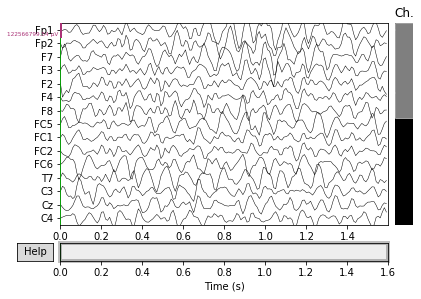

Effective window size : 1.600 (s)


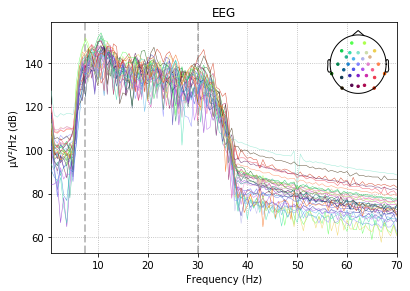

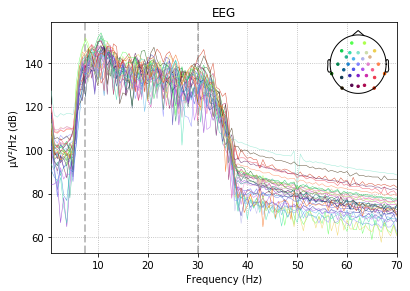

In [7]:
flt_rarray = ref.copy().filter( l_freq = 7.5, h_freq = 30, filter_length="auto")
flt_rarray.plot(n_channels = 15, scalings = "auto")
flt_rarray.plot_psd( fmin = 0.1, fmax = 70)